In [23]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from joblib import dump, load
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [24]:
dataset=pd.read_csv('twitter_training.csv',header=None)
dataset.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [25]:
files=['twitter_training.csv','twitter_validation.csv']
#train set
dataset_train=pd.read_csv(files[0],header=None)
dataset_train.drop(0,inplace=True,axis=1)
dataset_train.drop(1,inplace=True,axis=1)
titel=['sentiment','tweet']
dataset_train.columns=titel
dataset
dataset_train['sentiment']=dataset_train['sentiment'].replace({'Positive':1, 'Neutral': 0, 'Negative': 2})
dataset_train.head(100)
dataset_train=dataset_train[dataset_train['sentiment']!= 'Irrelevant']
#test set
dataset_test=pd.read_csv(files[1],header=None)
dataset_test.drop(0,inplace=True,axis=1)
dataset_test.drop(1,inplace=True,axis=1)
titel=['sentiment','tweet']
dataset_test.columns=titel
dataset
dataset_test['sentiment']=dataset_test['sentiment'].replace({'Positive':1, 'Neutral': 0, 'Negative': 2})
dataset_test.head(100)
dataset_test=dataset_test[dataset_test['sentiment']!= 'Irrelevant']

In [26]:
#clean Data
from nltk.stem import PorterStemmer
import pandas as pd
import re
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
nltk.download('words')
english_words = set(words.words())
stemmer=PorterStemmer()
# Define the patterns you want to remove
pattern = '[^a-z|A-Z|\s]|a{2,}|\s{2,}|â|Â|\n'
big_data=[dataset_train,dataset_test]
for data in big_data :
  for i in range(len(data)):
      try :
          #match unneeded words from text and substitute them with ""
          matched=re.findall(pattern,data['clean_text'][i])
          cleaned_text = re.sub(pattern, "", data['clean_text'][i])
          #nlp=spacy.blank("en")
          #doc=nlp(cleaned_text)  #split cleaned data into words and check for stop/english words
          filtered_words = []
          cleaned_list=cleaned_text.split(' ')
          for token in cleaned_list:
              stemmer.stem(token) # derive stem of words
              filtered_words.append(token)
          data['clean_text'][i] = ' '.join(filtered_words)
          if data['clean_text'][i]=='' or data['clean_text'][i]==' '  :
              #print("true")
              data=data.drop(data[i]) #get rid of empty lines
      except:
          pass

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [27]:
nan_indices = dataset_train['sentiment'].index[dataset_train['sentiment'].isna()]
print(nan_indices)
dataset_train.drop(nan_indices, inplace=True)
nan_indices = dataset_train['tweet'].index[dataset_train['tweet'].isna()]
print(nan_indices)
dataset_train.drop(nan_indices, inplace=True)
nan_indices = dataset_test['sentiment'].index[dataset_test['sentiment'].isna()]
print(nan_indices)
dataset_test.drop(nan_indices, inplace=True)
nan_indices = dataset_test['tweet'].index[dataset_test['tweet'].isna()]
print(nan_indices)
dataset_test.drop(nan_indices, inplace=True)
data = pd.concat([dataset_train, dataset_test], ignore_index=True)
print(data)


Int64Index([], dtype='int64')
Int64Index([   61,   553,   589,   745,  1105,  1106,  2413,  2929,  2983,
             2997,
            ...
            73761, 73762, 73763, 73855, 73971, 73972, 73973, 74421, 74422,
            74423],
           dtype='int64', length=571)
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
      sentiment                                              tweet
0             1  im getting on borderlands and i will murder yo...
1             1  I am coming to the borders and I will kill you...
2             1  im getting on borderlands and i will kill you ...
3             1  im coming on borderlands and i will murder you...
4             1  im getting on borderlands 2 and i will murder ...
...         ...                                                ...
61944         2  Please explain how this is possible! How can t...
61945         1  Good on Sony. As much as I want to see the new...
61946         1  Today sucked so it’s time to drink wine n play.

In [28]:
from nltk.tokenize import word_tokenize

from torch.nn.utils.rnn import pad_sequence
import torch
nltk.download('punkt')
# Tokenize the text data into words for each tweet
tokenized_text = [word_tokenize(text) for text in data['tweet']]

# Create a vocabulary set to store unique words from the tokenized text
vocab = set(word for tokens in tokenized_text for word in tokens)
vocab_size = len(vocab)
print("Vocabulary Size:", vocab_size)

# Create a dictionary to store the occurrence count of each word
word_occurrence = {}

# Count the occurrences of each word in the tokenized text
for tokens in tokenized_text:
    for word in tokens:
        if word in word_occurrence:
            word_occurrence[word] += 1
            if word_occurrence[word] > 10000:
                word_occurrence[word] = 10000
        else:
            word_occurrence[word] = 1

# Replace the words in tokenized text with their occurrence counts
tokenized_text_with_counts = [[word_occurrence[word] for word in tokens] for tokens in tokenized_text]


# Convert the tokenized text with word counts into torch tensors
tensor_sequences = [torch.tensor(sequence) for sequence in tokenized_text_with_counts]

# Pad the tensor sequences to create equal-length sequences for batch processing
padded_sequences = pad_sequence(tensor_sequences, batch_first=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary Size: 43675


In [29]:
print(padded_sequences.shape)
X=padded_sequences
y=data['sentiment'].values
print(X.shape)

torch.Size([61949, 198])
torch.Size([61949, 198])


In [30]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


# Train Word2Vec model on the tokenized_text data
model_w2v = Word2Vec(sentences=tokenized_text, vector_size=200, window=5, min_count=1, workers=4)

# Create a dictionary to store word embeddings (word vectors) for each word in the vocabulary
word_embeddings = {word: model_w2v.wv[word] for word in model_w2v.wv.key_to_index}

# Create a list of word embeddings for all words in the vocabulary
word_vector_list = [word_embeddings[word] for word in model_w2v.wv.key_to_index]

# Convert the list of word embeddings into a numpy array
word_embeddings_np = np.stack(word_vector_list)


# Print the shape of the word embeddings numpy array
print("Shape of word embeddings array:", word_embeddings_np.shape)

Shape of word embeddings array: (43675, 200)


In [31]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert X_train and y_train to PyTorch tensors
train_data_tensor = torch.tensor(X_train).float()
train_label_tensor = torch.tensor(y_train.astype(int)).float()

# Convert the data and labels to float32 data type
train_data_tensor = train_data_tensor.to(torch.float32)
train_label_tensor = train_label_tensor.to(torch.float32)

# Create a PyTorch TensorDataset using the training data and labels
train_dataset = TensorDataset(train_data_tensor, train_label_tensor)

# Convert X_test and y_test to PyTorch tensors and set their data type to float32
test_data_tensor = torch.tensor(X_test).to(torch.float32)
test_label_tensor = torch.tensor(y_test.astype(int)).to(torch.float32)

# Create a PyTorch TensorDataset using the test data and labels
test_dataset = TensorDataset(test_data_tensor, test_label_tensor)

# Create a DataLoader for training data with batch_size=32 and shuffle the data during training
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, drop_last=True)

# Create a DataLoader for test data with batch_size=32 and shuffle the data during testing
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True, drop_last=True)

<ipython-input-32-6e4e972c87dd>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensor = torch.tensor(X_train).float()
<ipython-input-32-6e4e972c87dd>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensor = torch.tensor(X_test).to(torch.float32)


In [33]:
# Get the shape of the input data (features) from the training dataset
input_data_shape = train_dataset.tensors[0].shape

# Get the shape of the labels from the training dataset
label_shape = train_dataset.tensors[1].shape

# Print the shape of the input data (features)
print("Input data shape:", input_data_shape)

# Print the shape of the labels
print("Label shape:", label_shape)

# Get the data type of the input data (features) from the training dataset
input_data_type = train_dataset.tensors[0].dtype

# Get the data type of the labels from the training dataset
label_data_type = train_dataset.tensors[1].dtype

# Print the data type of the input data (features)
print("Input data type:", input_data_type)

# Print the data type of the labels
print("Label data type:", label_data_type)

Input data shape: torch.Size([49559, 198])
Label shape: torch.Size([49559])
Input data type: torch.float32
Label data type: torch.float32


In [34]:
import torch.nn as nn
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * 4 , hidden_dim * (2 ))
        # The linear layer that calculates the attention scores
        self.att= nn.Linear(hidden_dim * 2  , 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.att(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, drop):
        super(LSTM_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        factor = 2  
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim)
        hidden=(h0,c0)
        return hidden

In [46]:
# Define the number of classes for classification
input_size = 3
# Define the hidden dimension for the LSTM model
hidden_dim = 128
# Set the learning rate for the optimizer
lr= 4e-3
# Define the number of LSTM layers
lstm_layers = 2
# Set the dropout rate for the LSTM model
dropout = 0.5

# Set the number of training epochs
epochs = 20
 
# Set the size of the vocabulary (number of unique words in the dataset)
vocab_size = 43675

# Create an instance of the LSTM Sentiment Classifier model with specified hyperparameters
model = LSTM_Model(vocab_size, 200, hidden_dim, input_size, lstm_layers, dropout)
 
# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(word_embeddings_np))

# Allow the embedding matrix to be fine-tuned during training for better adaptation to the dataset
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function) for the model's training
criterion = nn.NLLLoss()

# Set up the optimizer for training the model's parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-5)

# Print the model summary
print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(43675, 200)
  (lstm): LSTM(200, 100, num_layers=2, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=400, out_features=200, bias=True)
    (v): Linear(in_features=200, out_features=1, bias=False)
  )
  (fc): Linear(in_features=200, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [47]:
for e in range(epochs):
    model.train()
    print(e)
    for inputs, labels in train_loader:
        inputs = inputs.long()
        labels = labels.long()
        h = model.init_hidden(labels.size(0))
        print(inputs.shape)
        model.zero_grad()
        output, h = model(inputs,h)
        loss = criterion(output , labels)
        print(loss)
        loss.backward()
        optimizer.step()

Streaming output truncated to the last 5000 lines.
torch.Size([200, 198])
tensor(0.4280, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4671, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4989, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.5106, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.3899, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4585, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4129, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4567, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4222, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4629, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4080, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4039, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.5681, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
tensor(0.4302, grad_fn=<NllLossBackward0>)
torch.Size([200, 198])
te

In [48]:
model.eval()
y_pred_list = []
y_test_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
            inputs = inputs.long()
            labels = labels.long()
            test_h = model.init_hidden(labels.size(0))
            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())

In [49]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_list, y_pred_list)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8047540983606557


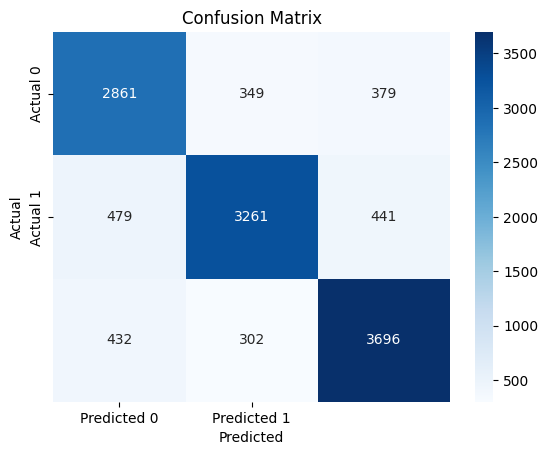

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test_list, y_pred_list)

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("confusion LSTM: 0.80 ACC.pdf")
plt.show()

In [63]:
pip install canvas

  Preparing metadata (setup.py) ... done
  Created wheel for canvas: filename=canvas-0.3-py3-none-any.whl size=2229 sha256=ae24eec19355d4004bddb57c7afa1dc20d7efb10be11985dd7130f9a4282a934
  Stored in directory: /root/.cache/pip/wheels/a3/0f/73/30a3bf2f5930ffde0e729d09e6ca6132bf0f03cfe354b68f42
Successfully built canvas


In [71]:
pip install scikit-learn tabulate fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40703 sha256=441b91fae7239b7eff05e496798cbca762511a4ebfec91268968f2d5013368a4
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [72]:
from sklearn.metrics import classification_report
from fpdf import FPDF
report=classification_report(y_test_list, y_pred_list)

pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

pdf.multi_cell(0, 10, "Classification Report")
pdf.ln()
pdf.multi_cell(0, 10, report)

pdf_filename = "classification_report.pdf"
pdf.output(pdf_filename)



''